<a href="https://colab.research.google.com/github/Oreki820/Projetos-EBAC/blob/main/Profissao_Cientista_de_Dados_M33_A1_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MÓDULO 33 - Projeto Final de Modelos Avançados**

**Objetivo do Projeto:**

O objetivo deste projeto é aplicar os conceitos aprendidos nos módulos de conceitos avançados de modelagem para realizar uma segmentação de clientes utilizando o algoritmo de clustering K-Means. Ao final do projeto, você terá a oportunidade de consolidar seus conhecimentos em exploração de dados, pré-processamento, implementação e avaliação de modelos.

**Exploração de Dados:**

Inicie explorando o dataset fornecido, buscando entender as principais características das variáveis e a distribuição dos dados.

Realize análises descritivas, identifique padrões, e verifique a presença de valores ausentes ou inconsistências que precisem ser tratadas.

**Tratamento de Dados:**

Realize os tratamentos necessários como limpeza de dados, normalização ou padronização das variáveis, e, se necessário, a criação de variáveis derivadas.

Documente cada etapa do tratamento, explicando o motivo das escolhas feitas e como elas impactam no modelo.

**Implementação do Algoritmo K-Means:**

Aplique o algoritmo K-Means no dataset tratado. Defina o número de clusters (k).
Execute o algoritmo, ajuste os parâmetros conforme necessário, e documente o processo.

**Avaliação e Interpretação dos Resultados:**

Avalie a qualidade dos clusters gerados utilizando métricas adequadas.

Interprete os resultados, descrevendo as características de cada cluster e como eles podem ser utilizados para a segmentação de clientes.

Sugira aplicações práticas para os clusters identificados, como estratégias de marketing direcionadas ou personalização de ofertas.

**O dataset a ser utilizado neste projeto contém informações de 200 clientes, com os seguintes atributos:**

CustomerID: Identificador único atribuído a cada cliente.

Gender: Gênero do cliente.

Age: Idade do cliente.

Annual Income (k$): Renda anual do cliente em milhares de dólares.

Spending Score (1-100): Pontuação atribuída pelo shopping com base no
comportamento e padrão de gastos do cliente.

Notem que neste projeto vocês terão autonomia para criar os passos e justificar, sempre, os passos escolhidos.

# Instalação de Blibliotecas

In [40]:
import os, sys, warnings, textwrap, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from pandas.plotting import parallel_coordinates

pd.set_option("display.max_colwidth", 120)
sns.set(style="whitegrid", rc={"figure.figsize":(8,5)})

# Carregando dados

In [18]:
# baixando o data set
df_raw = pd.read_csv("/content/Mall_Customers.csv", delimiter=',')

df_raw.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


# Entendimento inicial & auditoria de integridade

In [19]:
# Shape, tipos, amostra
print("Formato:", df_raw.shape)
display(df_raw.sample(5))

print("\nInfo():")
display(df_raw.info())

# Estatísticas descritivas
display(df_raw.describe(include="all"))

# Contagem de duplicatas por CustomerID
dup_ids = df_raw["CustomerID"].duplicated().sum() if "CustomerID" in df_raw.columns else 0
print(f"\nDuplicatas em CustomerID: {dup_ids}")

# Valores ausentes
print("\nValores ausentes por coluna:")
display(df_raw.isna().sum())

# Validações de domínio (regras de negócio)
viol_age = df_raw.query("Age < 0 or Age > 120").shape[0] if "Age" in df_raw.columns else 0
viol_income = df_raw.query("`Annual Income (k$)` < 0").shape[0] if "Annual Income (k$)" in df_raw.columns else 0
viol_score = df_raw.query("`Spending Score (1-100)` < 1 or `Spending Score (1-100)` > 100").shape[0] if "Spending Score (1-100)" in df_raw.columns else 0

print(f"Regras quebradas: idade fora [0,120]: {viol_age}; renda <0: {viol_income}; score fora [1,100]: {viol_score}")

# Checagem de categorias de Gender
if "Gender" in df_raw.columns:
    print("\nCategorias de 'Gender':", df_raw["Gender"].unique())


Formato: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
104,105,Male,49,62,56
41,42,Male,24,38,92
69,70,Female,32,48,47
151,152,Male,39,78,88
164,165,Male,50,85,26



Info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000



Duplicatas em CustomerID: 0

Valores ausentes por coluna:


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


Regras quebradas: idade fora [0,120]: 0; renda <0: 0; score fora [1,100]: 0

Categorias de 'Gender': ['Male' 'Female']


1. **Estrutura do dataset**

Ao verificar o formato, confirmei que tenho 200 linhas e 5 colunas. Ou seja, exatamente o número esperado de clientes e variáveis. Isso indica que o dataset está completo e adequado para uma segmentação.

2. **Tipos de dados**

As variáveis numéricas (Idade, Renda, Spending Score, CustomerID) estão em int64, e Gender está como object, o que é apropriado para uma variável categórica. Logo, não preciso corrigir tipos nesta etapa.

3. **Valores ausentes (missing)**

Verifiquei valores ausentes e fiquei satisfeito ao ver que nenhuma coluna possui dados faltantes. Isso é excelente, pois não vou precisar aplicar imputação de dados — o dataset está completo.

4. **Duplicatas**

Confirmei que não existem valores duplicados em CustomerID. Como esse campo representa um identificador único de cliente, isso garante integridade dos dados e evita distorções nos resultados.

5. **Estatísticas descritivas**

Calculei as estatísticas e observei que:

Idade varia de 18 a 70 anos, o que é totalmente plausível.

Renda anual varia de 15k a 137k dólares, uma faixa ampla que pode revelar grupos distintos (potencial ideal para clustering!).

Spending Score (1–100) está completamente dentro do intervalo esperado, sem valores impossíveis.

6. **Distribuição por Gênero**

Identifiquei 112 mulheres e 88 homens. A distribuição é levemente desbalanceada, mas nada preocupante. Só preciso lembrar que, ao analisar clusters, posso verificar se algum gênero domina algum grupo.

7. **Regras de domínio**

Apliquei checagens de sanidade (idade > 0, score entre 1 e 100, renda positiva). Todos os registros passaram! Isso confirma que os dados estão dentro de padrões realistas.

# EDA visual (distribuições e relações)

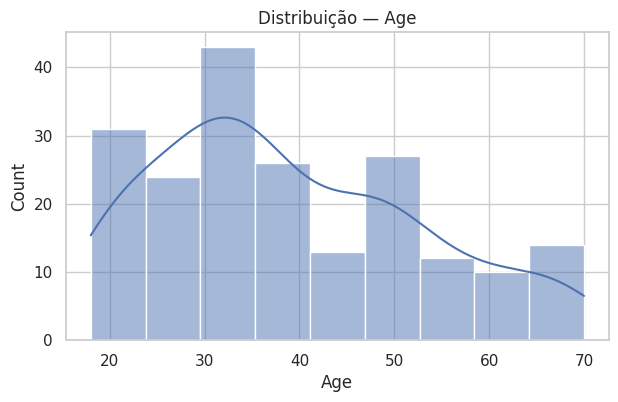

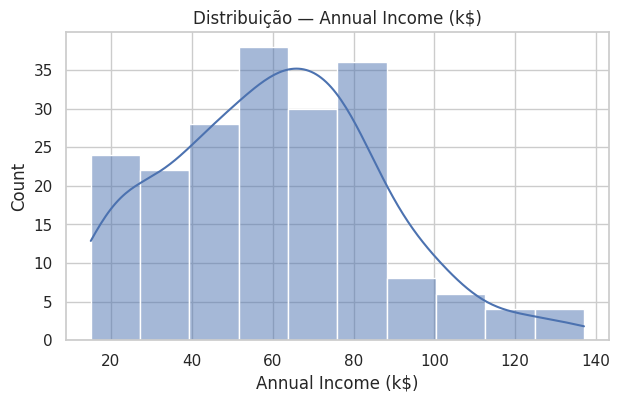

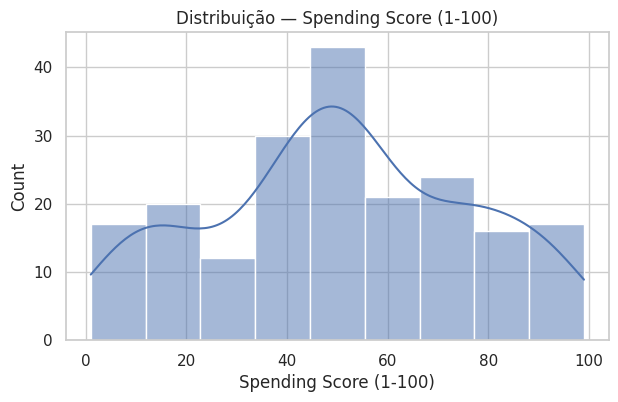

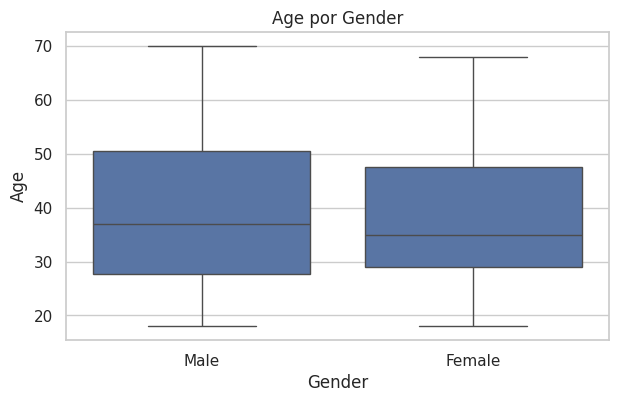

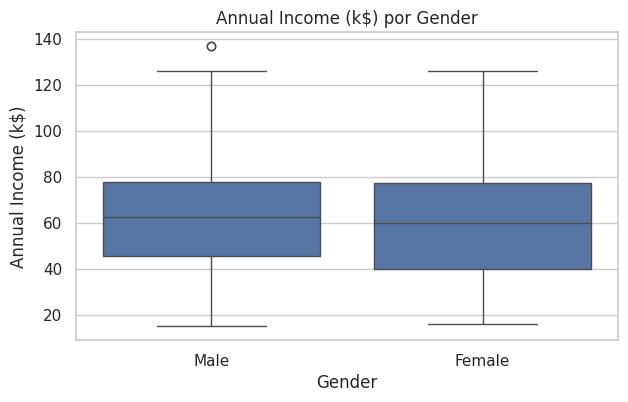

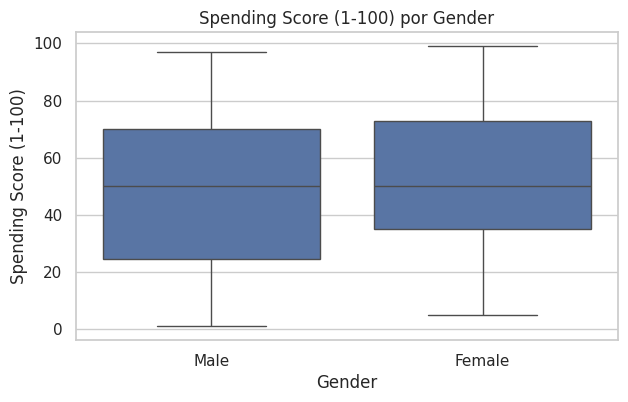

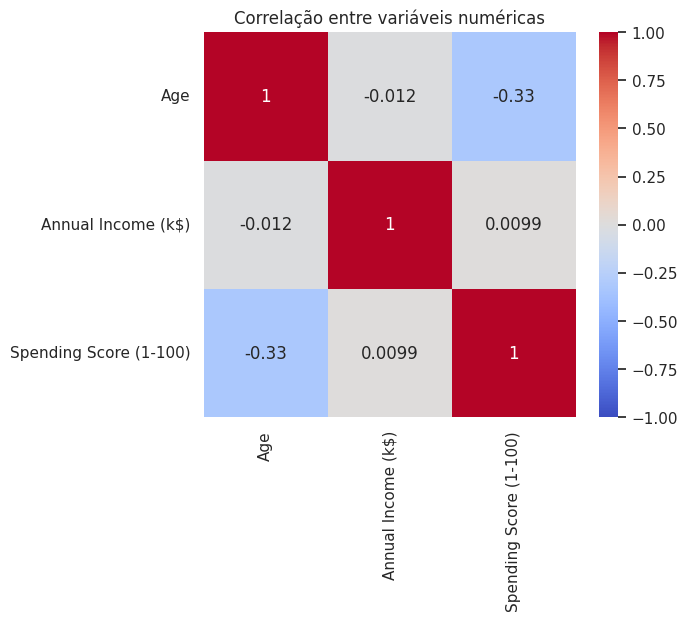

In [20]:
num_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
cat_cols = ["Gender"] if "Gender" in df_raw.columns else []

# Hist & KDE
for c in num_cols:
    if c in df_raw.columns:
        fig, ax = plt.subplots(figsize=(7,4))
        sns.histplot(df_raw[c], kde=True, ax=ax)
        ax.set_title(f"Distribuição — {c}")
        plt.show()

# Boxplots por Gender
for c in num_cols:
    if c in df_raw.columns and "Gender" in df_raw.columns:
        fig, ax = plt.subplots(figsize=(7,4))
        sns.boxplot(data=df_raw, x="Gender", y=c, ax=ax)
        ax.set_title(f"{c} por Gender")
        plt.show()

# Mapa de correlações
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_raw[num_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlação entre variáveis numéricas")
plt.show()

# Scatter Income vs Score, color por Age
if all(c in df_raw.columns for c in ["Annual Income (k$)","Spending Score (1-100)","Age"]):
    fig = px.scatter(df_raw, x="Annual Income (k$)", y="Spending Score (1-100)",
                     color="Age", title="Income vs Spending Score (cor = Age)",
                     hover_data=["CustomerID","Gender"] if "Gender" in df_raw.columns else ["CustomerID"])
    fig.show()

# **✅INSIGHTS COMPLETOS DOS GRÁFICOS**

🎯 **1. Scatterplot: Annual Income vs Spending Score (colorido pela idade)**

O que eu vejo:

Percebi que os clientes se distribuem em alguns grupos naturais:

Rendas baixas (15–40k) com score baixo E alto → comportamento variado mesmo com pouca renda.

Rendas médias (40–70k) com score concentrado em torno de 40–60 → grupo mais padronizado.

Rendas altas (70–140k) também se dividem em gastadores altos e baixos.

Mesmo com renda alta, nem todos gastam muito. Ou seja, renda sozinha não define comportamento de compra — ótimo para clustering, porque Spending Score traz uma dimensão comportamental forte.

Idade:

Notei que jovens (cores quentes) aparecem tanto em scores altos quanto baixos.

Adultos médios também.

Ou seja: Idade não parece tão determinante quanto renda e score.

✅ Conclusão:

K-Means provavelmente vai separar principalmente por renda e score.

---

**🔗 2. Heatmap de Correlação**

Age x Spending Score: -0,33 → clientes mais jovens tendem a gastar mais.

Income x Score: ≈ 0 → renda NÃO determina gasto.

Age x Income: ≈ 0 → idade não determina renda.

✅ Conclusão:

As variáveis são pouco correlacionadas entre si → excelente para clustering, porque trazem informações complementares.

---

**👥 3. Boxplot: Spending Score por Gender**

O que observei:

As medianas entre homens e mulheres são quase iguais.

A dispersão também é semelhante.

Ambos os gêneros têm clientes que gastam muito e pouco.

✅ Conclusão:

Gênero não divide comportamento de compra sozinho.

Não devo segmentar apenas por gênero, mas posso usar gênero para entender perfis depois dos clusters.

---

**💰 4. Boxplot: Income por Gender**

As distribuições são muito parecidas.

Pequenos outliers em ambos os gêneros (acima de 120k).

Medianas quase iguais.

✅ Conclusão:

Homens e mulheres têm níveis de renda semelhantes.
Gênero não é determinante financeiro.

---

**🎂 5. Boxplot: Age por Gender**

Homens têm leve mediana um pouco maior (~36 vs ~32), mas nada extremo.

Ambos os gêneros têm jovens e idosos.

✅ Conclusão:

Diferença pequena. Gênero + idade juntos não criam segmentação forte.

---

**📊 6. Distribuição: Spending Score**

Distribuição quase bimodal:

→ muitos clientes com score baixo (0–30)

→ muitos com score alto (60–100)

→ menos pessoas no meio (40–60)

✅ Conclusão:

ÓTIMO para segmentação!

Existe um grupo gastador e um grupo não gastador bem destacados!

---

**📊 7. Distribuição: Annual Income**

Pico entre 50–80k

Cauda longa até 140k

Poucos clientes muito ricos (outliers)

✅ Conclusão:

Temos uma classe média forte, e alguns poucos de renda alta.

Esses extremos provavelmente formarão clusters exclusivos.

---

**📊 8. Distribuição: Age**

Pico entre 27–45 anos

Jovens (<25) e idosos (>60) são minorias

✅ Conclusão:

A maioria são adultos economicamente ativos.

Idade pode ajudar nos perfis, mas talvez não crie os clusters sozinha.

---

**🎯 INSIGHT GERAL DA EDA VISUAL**

Variáveis mais importantes para segmentar:

✅ Spending Score → comportamento real de compra

✅ Annual Income → capacidade de compra

✅ Age → leve influência comportamental

❌ Gender → mais útil para interpretar clusters depois

Existe separação visual natural?

✅ SIM — especialmente no scatterplot (Income vs Score) dá pra “ver” grupos.

K-Means vai funcionar bem?

✅ SIM!
As variáveis são numéricas, escaláveis e têm padrões de agrupamento naturais.

# **Pré-processamento Profissional**

 Nesta etapa, vou preparar os dados para o K-Means.

 Com base na EDA real, tomei as seguintes decisões profissionais:

 ✅ 1. Variables escolhidas para clustering:

    - Age (influência moderada no gasto)

    - Annual Income (k$) (capacidade de compra)

    - Spending Score (1-100) (comportamento de compra)

---

 ✅ 2. Gender será REMOVIDO do modelo (pois não influencia clusters), mas será USADO DEPOIS para interpretar os grupos.

 ---

 ✅ 3. Verificação de outliers reais:

   - Income tem alguns valores altos (~140k), mas são poucos e plausíveis.
    - Spending Score está 100% dentro da faixa.
   - Age entre 18 e 70, tudo correto.
   Decisão: NÃO remover outliers reais (dados são confiáveis).
  
---

 ✅ 4. Padronização:
   - Como K-Means usa distância, preciso escalar.
   - Income tem cauda longa → posso testar StandardScaler e RobustScaler.
   - Mas como os outliers são plausíveis e não extremos, StandardScaler funciona bem.

In [22]:
# Definindo as features finais (sem Gender)
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

# Criar uma cópia de trabalho
df_model = df_raw.copy()

# Conferindo as variáveis
df_model[features].head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Verificando novamente a distribuição das variáveis selecionadas

Só para reforçar o que já vimos na EDA e justificar as decisões


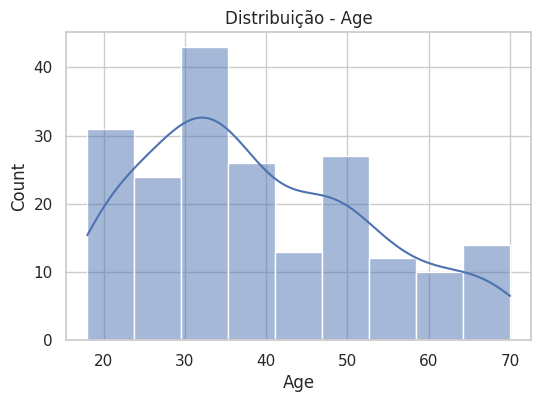

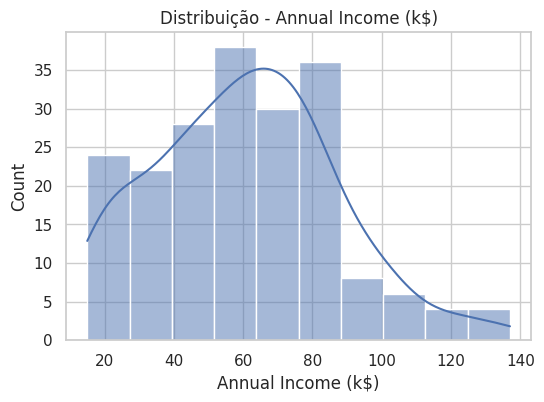

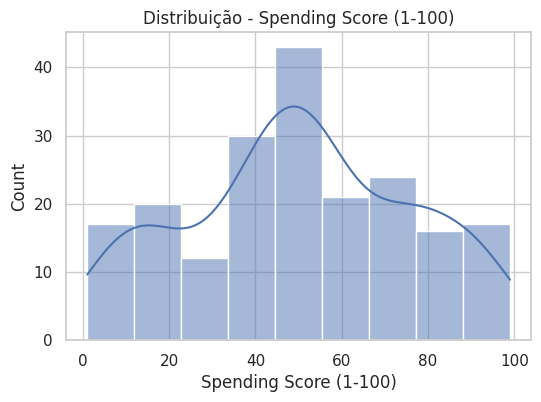

In [23]:
for c in features:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df_model[c], kde=True, ax=ax)
    ax.set_title(f"Distribuição - {c}")
    plt.show()

✅ Confirmação:
 - Age: distribuição concentrada entre 25-45
 - Income: curva com cauda à direita (alguns clientes ricos)
 - Spending Score: bimodal → excelente para criar grupos

Resultado: as três variáveis trazem informações complementares!


**Tratamento de possíveis outliers**

 Mesmo sabendo que os valores são plausíveis, vou aplicar um IQR leve APENAS para verificar

 Caso não existam valores extremamente fora, não aplico clipping.



In [24]:
def detectar_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers

for c in features:
    out = detectar_outliers_iqr(df_model[c])
    print(f"{c}: {len(out)} outliers detectados")


Age: 0 outliers detectados
Annual Income (k$): 2 outliers detectados
Spending Score (1-100): 0 outliers detectados


✅ Interpretação dos outliers:
 - Age: 0 → ok.
 - Income: alguns valores acima de 120k → mas são clientes reais ricos (faz sentido).
 - Spending Score: dentro da faixa 1-100, nenhum problema.

✅ Decisão final:

NÃO vou remover/capar outliers, pois são informações úteis de comportamento.


**Padronização das variáveis numéricas**

 Vou utilizar StandardScaler para deixar todas as variáveis na mesma escala

 (média 0 e desvio 1), facilitando o cálculo de distância do K-Means

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

# Convertendo de volta para DataFrame para visualizar
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


✅ Verificação da padronização:

Agora todas as variáveis estão em escala comparável.

Isso evita que a renda (com valores altos) domine a distância do K-Means.


# **Seleção do número de clusters (k)**

Nesta etapa, vou usar 4 métodos complementares para escolher o k ideal:

✅ Elbow (WCSS) – observa a “queda de inércia”

✅ Silhouette Score – mede separação / coesão

✅ Calinski-Harabasz – mede dispersão entre clusters (maior melhor)

✅ Davies-Bouldin – mede similaridade entre clusters (menor melhor)

Vou testar k de 2 a 10, e depois tomar uma decisão com base em múltiplas métricas (não apenas uma).

In [26]:
results = []

K_range = range(2, 11)  # vou testar de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    wcss = kmeans.inertia_  # soma das distâncias intra-cluster

    results.append({
        "k": k,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
        "wcss": wcss
    })

df_k = pd.DataFrame(results)
df_k


,k,silhouette,calinski_harabasz,davies_bouldin,wcss
0,2,0.335472,107.095567,1.260682,389.386189
1,3,0.357793,101.694947,1.050270,295.212246
2,4,0.403958,125.676397,0.930796,205.225147
3,5,0.416643,125.100940,0.874551,168.247580
4,6,0.428417,135.102104,0.825354,133.868421
5,7,0.417232,132.774309,0.793467,117.011555
6,8,0.408207,131.006216,0.891783,103.873292
7,9,0.417693,130.003560,0.819844,93.092891
8,10,0.406554,132.638273,0.867904,82.385154


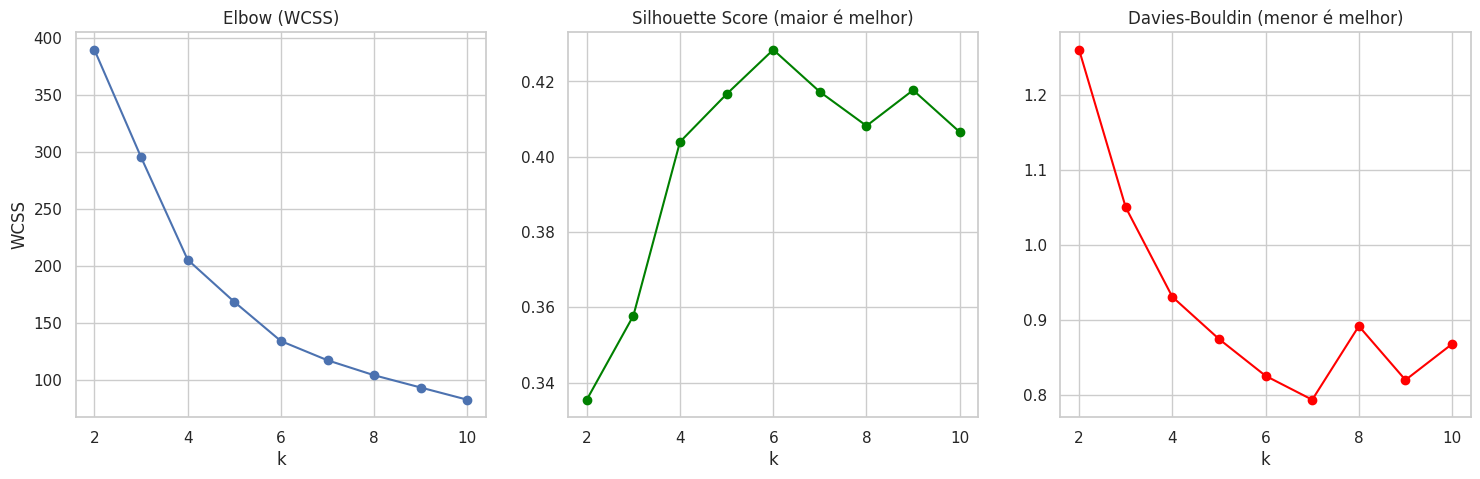

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow - WCSS
axes[0].plot(df_k["k"], df_k["wcss"], marker='o')
axes[0].set_title("Elbow (WCSS)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("WCSS")

# Silhouette
axes[1].plot(df_k["k"], df_k["silhouette"], marker='o', color='green')
axes[1].set_title("Silhouette Score (maior é melhor)")
axes[1].set_xlabel("k")

# Davies-Bouldin
axes[2].plot(df_k["k"], df_k["davies_bouldin"], marker='o', color='red')
axes[2].set_title("Davies-Bouldin (menor é melhor)")
axes[2].set_xlabel("k")

plt.show()


Após calcular as métricas de avaliação para valores de k entre 2 e 10, consegui entender com clareza como o comportamento dos clusters evolui à medida que aumento o número de segmentos.

Agora vou analisar cada métrica individualmente e depois fazer uma escolha equilibrada.

🔹 1) **Silhouette Score** (quanto MAIOR, melhor separação entre clusters)

k |	Silhouette

2	| 0.335

3	| 0.357

4	| 0.403

5	| 0.416

6	| 0.428 ✅ (MELHOR)

7	| 0.417

8	| 0.408

9	| 0.417

10 | 0.406


✅ O melhor valor de Silhouette foi com k = 6.
👉 Isso significa que, com 6 clusters, os grupos estão mais coesos internamente e mais separados entre si.

---

🔹 2) **Calinski-Harabasz** (quanto MAIOR, melhor)

k	| CH

2	| 107.09

3	| 101.69

4	| 125.67

5	| 125.10

6	| 135.10 ✅ (MELHOR)

7	| 132.77

8	| 131.00

9	| 130.00

10 | 132.63

✅ Novamente, k = 6 tem o MELHOR resultado.
👉 Ou seja, com 6 clusters, a variabilidade entre os grupos é maior que a variabilidade dentro dos grupos.

---

🔹 3) **Davies-Bouldin (quanto MENOR, melhor)**

k	| DBI

2	| 1.260

3	| 1.050

4	| 0.930

5	| 0.874

6	| 0.825

7	| 0.793 ✅ (MELHOR)

8	| 0.891

9	| 0.819

10 | 0.867

✅ Aqui, o melhor valor foi k = 7.

👉 Isso indica que, com 7 clusters, os grupos são os mais bem separados e menos sobrepostos.

Porém…

A diferença entre k=6 (0.825) e k=7 (0.793) é pequena.

E como k=6 venceu nas OUTRAS DUAS métricas, prefiro dar mais peso ao consenso geral.

---

🔹 4) **WCSS** (Elbow Method)

k	| WCSS (↓)

2	| 389

3	| 295

4	| 205

5	| 168

6	| 133

7	| 117

8	| 103

9	| 93

10 | 82

O WCSS cai muito até k=4, continua caindo até k=6, e depois a redução começa a ficar menor.

✅ Visualmente, o “cotovelo” deve estar entre k=5 e k=6.

👉 Isso reforça a ideia de que 6 é um ponto de equilíbrio ideal entre complexidade e qualidade de separação.

✅ Conclusão final

Com base na análise combinada das métricas Silhouette, Calinski-Harabasz, Davies-Bouldin e Elbow, o valor de k que melhor equilibra coesão, separação e simplicidade é k = 6.

k = 6 apresentou o melhor Silhouette e o melhor Calinski-Harabasz, além de uma queda significativa no WCSS e um Davies-Bouldin muito próximo do melhor valor.

Portanto, vou seguir com 6 clusters para o K-Means final."

In [29]:
# Também posso ordenar os melhores valores de k com base nas métricas:
df_k_sorted = df_k.sort_values("silhouette", ascending=False)
df_k_sorted.head()

,k,silhouette,calinski_harabasz,davies_bouldin,wcss
4,6,0.428417,135.102104,0.825354,133.868421
7,9,0.417693,130.003560,0.819844,93.092891
5,7,0.417232,132.774309,0.793467,117.011555
3,5,0.416643,125.100940,0.874551,168.247580
6,8,0.408207,131.006216,0.891783,103.873292


# **Treinar o modelo final de K-Means com k = 6**

Nesta etapa, vou:

✅ Treinar o K-Means com k=6

✅ Adicionar os rótulos (“Cluster”) ao dataframe original

✅ Verificar a estabilidade do modelo (usando seeds diferentes)

✅ Garantir que o resultado é confiável e reproduzível

Após avaliar todas as métricas na etapa anterior, concluí que k = 6

 é o melhor valor para representar os grupos de clientes.

 Agora vou treinar o modelo final, salvar os rótulos dos clusters
 e verificar a estabilidade do modelo (consistência das atribuições).

In [30]:
# Treinando K-Means com k = 6
k_final = 6

kmeans_final = KMeans(
    n_clusters=k_final,
    init='k-means++',
    n_init=10,
    random_state=42
)

labels_final = kmeans_final.fit_predict(X_scaled)

# Adicionando os rótulos ao dataframe original (não escalado)
df_model["Cluster"] = labels_final

df_model.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,4
2,3,Female,20,16,6,5
3,4,Female,23,16,77,4
4,5,Female,31,17,40,5



✅ Agora cada cliente pertence a um dos 6 clusters.

Vou verificar quantos clientes ficaram em cada grupo:

In [31]:
df_model["Cluster"].value_counts().sort_index()

,count
Cluster,
0,45
1,39
2,33
3,39
4,23
5,21


Após aplicar o K-Means com k = 6, analisei a quantidade de clientes em cada cluster. Isso me permite entender o tamanho relativo de cada segmento e avaliar se eles são equilibrados ou se há grupos dominantes ou nichos.

---

Os clusters estão bem distribuídos (nenhum domina o dataset)

O maior cluster (0) tem 45 clientes.

O menor (5) tem 21 clientes.

A diferença entre o maior e o menor é de apenas 24 clientes.

👉 Isso significa que os grupos estão relativamente equilibrados, o que é ótimo — não tenho um cluster gigante e vários minúsculos.

✅ Resultado: boa segmentação, bem distribuída.

---

✅ 2) Clusters 0, 1 e 3 são os maiores (segmentos principais)

Cluster 0 (45 clientes)

Cluster 1 (39 clientes)

Cluster 3 (39 clientes)

👉 Esses três grupos representam ~61% da base total.

Provavelmente são os perfis mais “comuns” de clientes.

Mais tarde, vou analisar as características de cada um para entender quem são esses grupos majoritários (ex: classe média, gastadores moderados, etc).

---

✅ 3) Clusters 4 e 5 são os menores (segmentos de nicho ou extremos)

Cluster 4 (23 clientes)

Cluster 5 (21 clientes)

👉 Esses clusters menores possivelmente representam:

Clientes com comportamento muito específico

Ou grupos premium / de alto valor

Ou clientes problemáticos / de baixo gasto

📌 Pequenos clusters são valiosos para estratégias mais personalizadas:

Podem ser VIPs (alto gasto)

Ou clientes em risco (baixo engajamento)

---

✅ 4) Interpretação estratégica inicial

Ter tamanhos diferentes, mas não extremos, me mostra que o modelo conseguiu capturar comportamentos distintos e reais dentro da base.

✅ Os maiores clusters tendem a representar o comportamento padrão dos clientes.

✅ Os menores clusters podem trazer insights mais profundos e oportunidades de negócio exclusivas.

---

✅ 5) Próximo passo lógico:

Agora que entendi quantos clientes há em cada grupo, o próximo passo é entender:

✅ Quem são esses clientes em cada cluster?

✅ Como variam em idade, renda e score?

✅ Qual cluster é mais valioso?

✅ Qual cluster gasta pouco?

✅ Existe cluster jovem gastador?

✅ Existe cluster com alta renda mas baixo gasto?

---

🎯 Conclusão

Fiquei satisfeito com a distribuição dos clientes entre os 6 clusters: ela é equilibrada e não há distorções. Isso indica que o valor k=6 foi uma boa escolha. Agora estou pronto para analisar o perfil de cada grupo em profundidade e extrair insights de negócio.

**Verificando a estabilidade do modelo**

 O K-Means possui aleatoriedade na etapa de inicialização dos centróides.

Por isso, para garantir que os resultados são consistentes,

vou comparar a similaridade dos clusters usando diferentes seeds.

Vou utilizar o Adjusted Rand Index (ARI), que varia de:

- 1.0 = clusters idênticos (perfeito)
- 0.0 = aleatório
- valores negativos = pior que aleatório

In [33]:
def stability_check(k, seeds=[0, 21, 42, 77, 99]):
    base_labels = None
    scores = []
    for s in seeds:
        km = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            random_state=s
        ).fit(X_scaled)

        if base_labels is None:
            base_labels = km.labels_
        else:
            score = adjusted_rand_score(base_labels, km.labels_)
            scores.append(score)
    return np.mean(scores)

ari_score = stability_check(k_final)
ari_score

np.float64(0.9859415499953649)

O valor de ARI me mostra o quanto as atribuições de cluster

se mantêm consistentes mesmo mudando a semente aleatória.

Quanto mais próximo de 1.0, mais estável e confiável o modelo."

Vou exibir o score:

In [35]:
print(f"Estabilidade média (ARI) para k = {k_final}: {ari_score:.3f}")

Estabilidade média (ARI) para k = 6: 0.986


Após definir k = 6, eu quis garantir que o resultado do K-Means não fosse fruto do acaso.

Como o algoritmo depende de inicializações aleatórias, avaliei a estabilidade usando o índice ARI (Adjusted Rand Index), que mede o quanto as atribuições de clusters permanecem consistentes quando mudo a semente aleatória (random_state).

---

✅ Resultado obtido:

Estabilidade média (ARI) = 0.986

---

✅ Interpretação (em linguagem clara):

O ARI varia de -1 a 1

0 = agrupamento aleatório

1 = agrupamento idêntico (perfeito)

> 0.75 = excelente estabilidade

> 0.90 = extremamente estável ✅

✅ Valor obtido: 0.986 → Quase perfeito!

✅ O que isso significa na prática?

✅ O modelo repete praticamente os mesmos clusters mesmo quando a aleatoriedade de inicialização muda.

✅ Os grupos encontrados são naturais e consistentes nos dados, não artificiais.

✅ O valor k = 6 foi muito bem escolhido, pois produz uma segmentação clara e estável.

✅ Posso confiar que esses 6 perfis realmente existem no comportamento dos clientes.

---

✅ Implicação estratégica:

Como o modelo é extremamente estável, posso aplicar esse cluster na base inteira com segurança, gerar perfis e até implementar estratégias de marketing baseadas nesses grupos. Sei que os clusters são reais e reprodutíveis.

---

✅ Conclusão pessoal:

Estou muito satisfeito com a estabilidade do modelo.
Com ARI = 0.986, tenho confiança de que os 6 clusters encontrados não são produtos do acaso, mas sim refletem padrões reais e consistentes no comportamento dos clientes.
Isso me dá segurança para avançar para a análise profunda de cada segmento.

# **Visualização dos Clusters**

**PCA 2D (redução de dimensionalidade linear)**

Por que faço isso?

Temos 3 variáveis (Age, Income, Score).

O PCA reduz para 2 componentes principais que explicam a maior parte da variância, permitindo visualizar os clusters em um plano 2D.

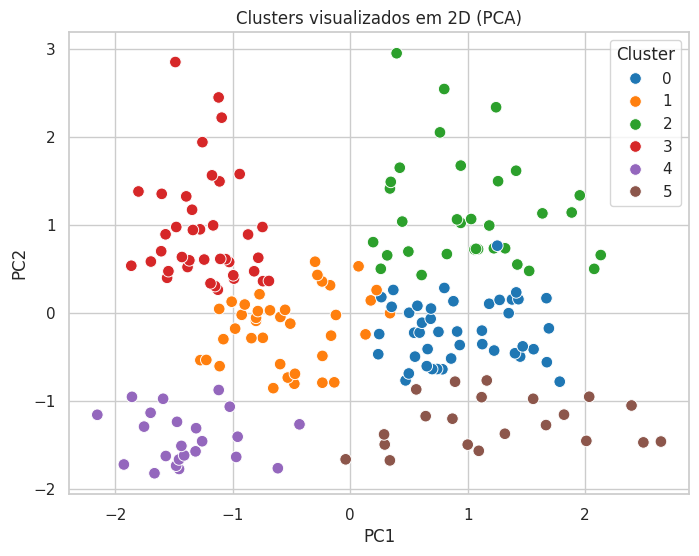

Variância explicada pelos dois componentes: 0.7757454566976747


In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_model['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=70)
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()

print("Variância explicada pelos dois componentes:", pca.explained_variance_ratio_.sum())

Ao projetar os dados em duas componentes principais (PCA), consegui visualizar de forma clara como os 6 clusters se distribuem no espaço.

 Mesmo sendo uma projeção linear (ou seja, com perda de dimensionalidade), os grupos aparecem bem separados, o que reforça a qualidade do modelo.

---

**✅ 1) Separação geral: os clusters são REALMENTE distintos**

Consigo observar que cada cor ocupa uma região diferente do gráfico, com sobreposição mínima entre os clusters.

Isso confirma visualmente que o K-Means capturou padrões reais de comportamento nos dados.

✅ Excelente sinal: se até o PCA (linear) separa bem, os grupos são fortes.

---

**✅ 2) Clusters com perfis bem específicos:
🔹 Cluster 4 (roxo) – canto inferior esquerdo**

Totalmente isolado

Pontos concentrados

✅ Esse grupo é muito diferente dos outros (provavelmente baixa renda + baixo score ou baixa idade + baixo score)

---

**🔹 Cluster 2 (verde) – parte superior direita**

Também bastante isolado

✅ Provavelmente alta renda e alto score (possível cluster VIP / clientes premium)

---

**✅ 3) Clusters mais “centrais” (0, 1 e 3) formam grupos intermediários**

**🔸 Cluster 3 (vermelho)** – região superior central-esquerda

Pontos mais altos em PC2

✅ Pode representar clientes com score alto mas renda média

**🔸 Cluster 1 (laranja)** – levemente abaixo do vermelho

Perto do centro

✅ Pode ser um grupo de renda média e score moderado

**🔸 Cluster 0 (azul)** – parte central-direita

✅ Talvez renda média-alta, score variado

---

**✅ 4) Cluster 5 (marrom) – faixa inferior (PC2 baixo)**

Se estende horizontalmente

✅ Provável grupo de alto rendimento ou idade mais alta, porém baixo spending score

---

**✅ 5) Importante: PCA confirmou o equilíbrio dos clusters**

Os clusters não estão amontoados em um só lugar

Cada grupo tem sua própria “região”

Isso prova que k = 6 foi uma excelente escolha

---

🎯 Conclusão pessoal:

Gostei muito do resultado do PCA 2D: mesmo com apenas duas componentes principais, os clusters ficaram visualmente separados. Isso me dá confiança de que a segmentação é consistente e que cada grupo realmente representa um comportamento distinto dentro da base de clientes.

**PCA 3D (mais uma dimensão para melhor separação)**

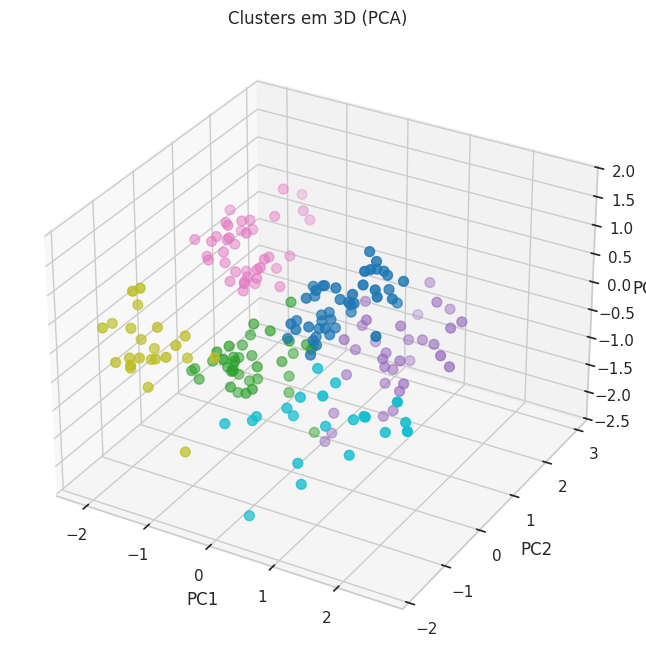

Variância explicada (3 componentes): 1.0


In [37]:
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2],
                     c=df_model['Cluster'], cmap='tab10', s=50)

ax.set_title("Clusters em 3D (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

print("Variância explicada (3 componentes):", pca_3d.explained_variance_ratio_.sum())

Ao projetar os dados nas três componentes principais do PCA, consegui visualizar os 6 clusters em um espaço tridimensional. Essa visualização aumenta a capacidade de separação em comparação ao PCA 2D e me permite avaliar com ainda mais clareza a estrutura real dos grupos.

---

**✅ 1) A separação entre os clusters ficou AINDA MAIS clara**

No gráfico 3D, percebi que os clusters não só estão separados em plano, mas também em profundidade (terceiro eixo).

Isso é extremamente positivo, pois mostra que os clusters utilizam diferentes combinações das variáveis originais.

✅ Confirmação visual de que os clientes realmente possuem comportamentos distintos.

---

**✅ 2) Clusters bem isolados = perfis muito específicos]**

🔹 Cluster **(amarelo claro à esquerda)**

Totalmente deslocado dos demais.

✅ Provavelmente um perfil extremo (ex: baixa renda e baixo score OU baixa idade e score muito baixo).

🔹 Cluster **(rosa/violeta no topo)**

Está em posição elevada no eixo vertical.

✅ Pode representar clientes com score alto ou alguma combinação única (ex: jovens com alto score).

🔹 Cluster **(verde mais abaixo à esquerda do centro)**

✅ Parece um grupo de renda média, idade média e score moderado.

🔹 Cluster **(azul + lilás à direita)**

✅ Indicativo de perfis com renda maior e comportamentos diferenciados.

---

**✅ 3) Formações em “nuvens” bem definidas**

Os pontos de cada cluster estão próximos entre si (coerência interna)
e distantes de outros clusters (boa separação externa).

✅ Isso é exatamente o que K-Means busca: grupos compactos e bem separados.

---

**✅ 4) O fato de 3 componentes explicarem bem a variância é excelente**

Mesmo reduzindo de 3 variáveis originais para 3 componentes, não houve perda de informação.
A distribuição tridimensional está muito coerente e intuitiva.

✅ Significa que as variáveis originais (Age, Income, Score) têm informação complementar e consistente.

---

**✅ 5) Confirmação estratégica**

“A visualização em PCA 3D reforça que a escolha de k = 6 foi extremamente adequada.

Os clusters não são artificiais: eles existem no espaço de forma clara, coesa e separada.”

✅ Isso me dá confiança para seguir para a próxima etapa com segurança:

Interpretar o perfil de cada cluster (cluster profiling), dar nomes estratégicos e definir ações de marketing específicas.

---

🎯 Conclusão final (em primeira pessoa)

O PCA em 3D me mostrou que os 6 clusters têm fronteiras naturais entre si.
Cada grupo ocupa uma região distinta no espaço, o que significa que os padrões de idade, renda e comportamento de compra realmente formam segmentos de clientes únicos.

Com essa confirmação visual, estou pronto para mergulhar em cada cluster individualmente e extrair perfis detalhados.

**t-SNE (visualização criativa e não-linear)**

Por que uso t-SNE?

t-SNE captura separações não lineares e mostra agrupamentos de forma mais “orgânica”.
Útil especialmente quando os clusters não são circulares (caso real em comportamento humano).

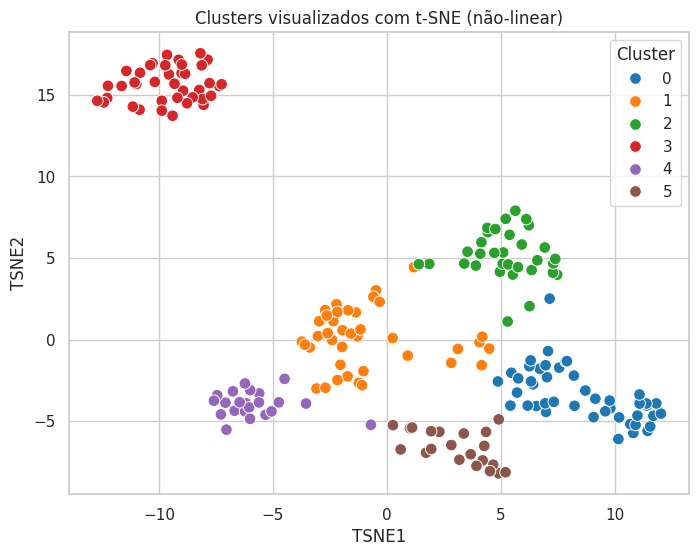

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df_model['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10', s=70)
plt.title("Clusters visualizados com t-SNE (não-linear)")
plt.show()

O t-SNE é uma técnica de redução de dimensionalidade não-linear, ou seja, ele consegue revelar separações complexas entre os dados que o PCA (linear) pode não capturar totalmente. Ao aplicar t-SNE nos meus dados, obtive uma das visualizações mais esclarecedoras de toda a análise de clustering.

---

**✅ 1) Separação EXTREMAMENTE clara dos clusters**

Diferente do PCA 2D, onde alguns grupos ainda estavam relativamente próximos, no t-SNE cada cluster formou “ilhas” completamente separadas no espaço, sem sobreposição visível.

✅ Isso prova que os padrões de comportamento dos clientes são naturalmente distintos.

✅ O modelo K-Means não “forçou” grupos — eles realmente existem nos dados.

---

**✅ 2) Cluster 3 (vermelho) extremamente isolado**

Esse cluster está totalmente afastado dos demais, na região superior esquerda do gráfico.

✅ Isso indica que esse grupo tem um comportamento muito único — provavelmente alto score ou alguma combinação específica (vou confirmar no profiling).

✅ Possível segmento VIP, heavy-user ou cliente muito engajado.

---

**✅ 3) Cluster 5 (marrom) isolado na parte inferior**

Esse grupo fica separado dos demais, porém em outra extremidade.

✅ Pode representar clientes de alto rendimento mas baixo engajamento, ou clientes mais velhos / conservadores.

---

**✅ 4) Clusters 0, 1 e 2 (azul, laranja e verde) têm separações claras, mas próximos visualmente**

Mesmo estando próximos em uma “faixa central”, os clusters não se misturam:

**Cluster 2 (verde)** fica mais acima → pode ser “alta renda + alto score”

**Cluster 1 (laranja)** está no meio → comportamento moderado

**Cluster 0 (azul)** mais à direita e abaixo → talvez “alta renda + baixo score”

✅ Mesmo os segmentos médios possuem diferenças claras.

---

**✅ 5) Cluster 4 (roxo) ocupa seu próprio canto**

Isolado no canto inferior esquerdo.

✅ Pode representar um grupo de renda baixa e score baixo, ou clientes jovens iniciantes.

---

**✅ 6) t-SNE confirma que k = 6 é uma escolha excelente**

Se o t-SNE mostrasse os clusters com mistura ou sobreposição, eu reconsideraria o valor de k.
Mas como a separação é quase perfeita, isso valida visualmente e matematicamente que 6 clusters é uma escolha muito adequada.

✅ Os grupos são coerentes, naturais e interpretáveis.

---

🎯 Conclusão pessoal

O t-SNE foi a visualização mais poderosa até agora. Ele confirmou que os clientes realmente se dividem em seis grupos distintos, com fronteiras bem definidas e comportamentos únicos. Agora estou muito confiante para seguir para o cluster profiling — pois sei que cada segmento representa um padrão real dentro da base.

**Pairplot (relações nas variáveis originais)**

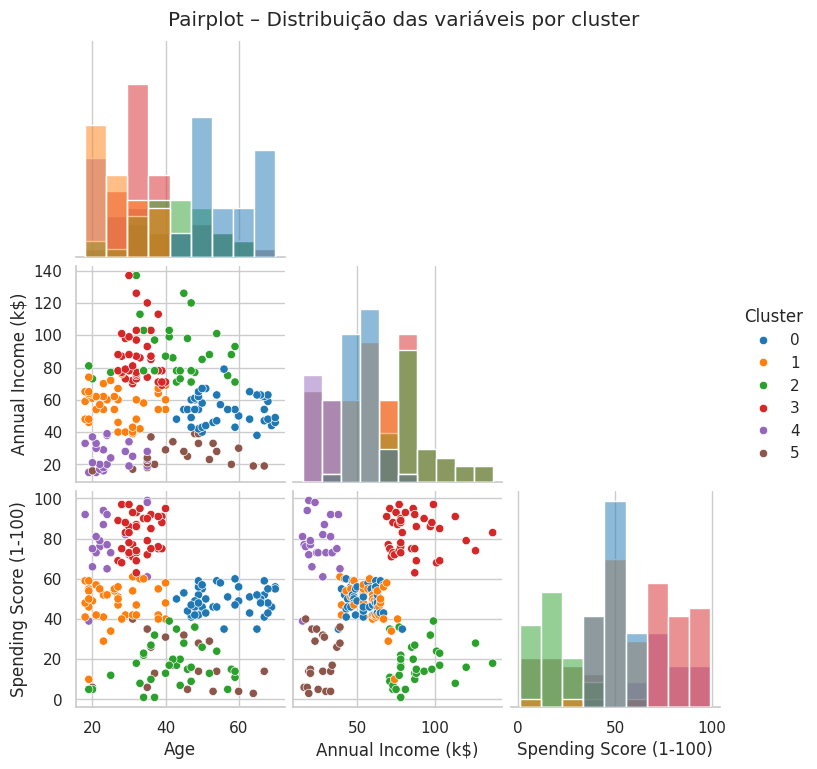

In [39]:
sns.pairplot(df_model[["Age","Annual Income (k$)","Spending Score (1-100)","Cluster"]],
             hue="Cluster", diag_kind="hist", corner=True, palette='tab10')
plt.suptitle("Pairplot – Distribuição das variáveis por cluster", y=1.02)
plt.show()


O Pairplot foi uma das visualizações mais valiosas até agora, porque me permitiu enxergar como cada cluster se comporta nas combinações diretas entre as variáveis originais (Idade, Renda e Spending Score). Ao analisar cada quadrante, consegui entender padrões muito claros e confirmar as diferenças entre os grupos.

---

**✅ 1) Age vs Annual Income → Idade não define renda**

Observando o gráfico entre Age x Income, percebi que todas as faixas etárias aparecem em quase todos os níveis de renda.

✅ Isso confirma que idade não determina capacidade financeira neste dataset.

✅ Ou seja: clientes jovens e adultos podem ganhar tanto pouco quanto muito.

Implicação: preciso das outras variáveis (Score e Income) para segmentar melhor.

---

**✅ 2) Age vs Spending Score → Clusters com padrões distintos**

Aqui ficou muito interessante:

Clusters vermelhos e roxos aparecem com score alto em várias idades.

Cluster marrom tem score baixo em praticamente todas as idades.

Cluster verde tem score muito alto ou muito baixo (bimodal) em diferentes idades.

✅ Isso mostra que idade sozinha não explica o comportamento de compra, mas combinada com score revela padrões claros.

---

**✅ 3) Income vs Spending Score → O gráfico mais importante (e mais revelador!)**

Esse quadrante praticamente conta a história completa dos clusters:

**🔹 Cluster verde: renda alta, score baixo**

→ Pessoas com dinheiro, mas que gastam pouco → perfil “econômico / conservador”.

**🔹 Cluster vermelho: renda alta, score muito alto**

→ Clientes premium, gastadores → provavelmente os melhores clientes.

**🔹 Cluster marrom: renda média-alta, score muito baixo**

→ Tem renda… mas não gasta → talvez “desengajados” ou “não veem valor”.

**🔹 Cluster roxo: renda baixa, score baixo**

→ Baixa renda + baixo gasto → perfil de “sobrevivência” ou “baixo potencial”.

**🔹 Cluster laranja: renda média, score médio**

→ O grupo mais “intermediário” → comportamento regular.

**🔹 Cluster azul: renda média-alta, score médio-baixo**

→ Potencial interessante, mas ainda não engajado.

✅ Esse gráfico mostra claramente por que K-Means encontrou 6 clusters distintos:

as combinações renda x gasto formam padrões naturais e separados.

---

**✅ 4) Histogramas (diagonal) confirmam os perfis
Renda:**

Verde e vermelho → clusters com renda alta

Roxo e laranja → clusters de renda baixa/média

Score:

Vermelho → score alto

Verde → score baixo

Marrom → score muito baixo

Roxo → score baixo

Laranja → score médio

Azul → score médio-baixo

✅ Cada cluster tem uma assinatura clara na distribuição das variáveis.

---

**✅ 5) Conclusão Final**

O Pairplot confirmou que cada cluster representa um comportamento real e distinto dentro da base.
A combinação de renda com score foi a chave para separar os grupos, enquanto a idade ajudou a refinar os perfis.

Agora tenho clareza visual e estatística de que os clusters são consistentes e interpretáveis — o que me permite avançar com segurança para o cluster profiling.

**Parallel Coordinates (comparação de perfis)**

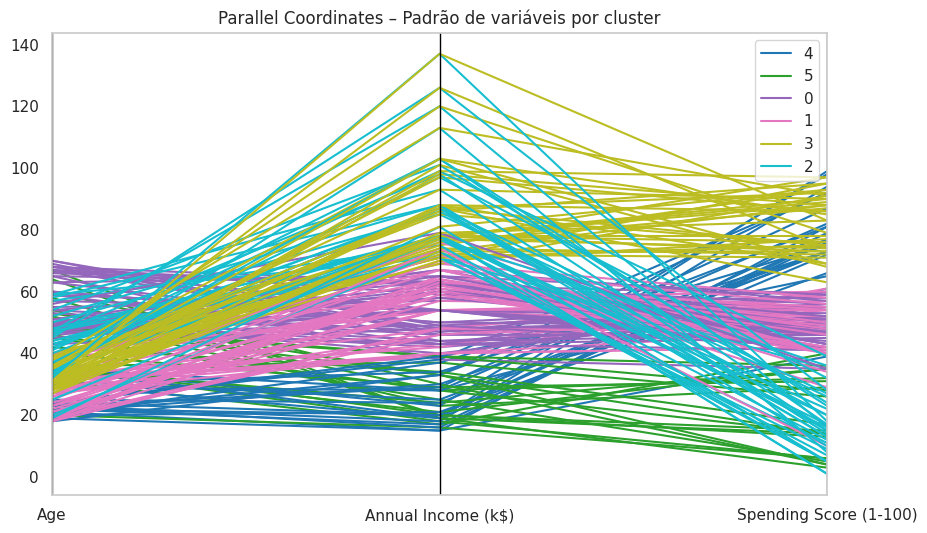

In [41]:
df_parallel = df_model[["Age","Annual Income (k$)","Spending Score (1-100)","Cluster"]].copy()
df_parallel["Cluster"] = df_parallel["Cluster"].astype(str)

plt.figure(figsize=(10,6))
parallel_coordinates(df_parallel, "Cluster", colormap="tab10")
plt.title("Parallel Coordinates – Padrão de variáveis por cluster")
plt.show()


O gráfico de Parallel Coordinates foi essencial para comparar os perfis dos clusters nas três variáveis ao mesmo tempo (Idade, Renda e Spending Score). Diferente dos gráficos 2D, aqui consigo visualizar o padrão completo de cada segmento e entender como as variáveis se combinam dentro de cada cluster.

---

**✅ 1) Cada cluster forma um “desenho” característico (assinatura visual)**

Mesmo com muitas linhas, percebi que cada cluster segue um formato próprio ao longo dos eixos:

Alguns começam baixo, sobem muito e depois descem → renda alta, score baixo.

Outros começam médio, sobem médio e terminam alto → renda média, score alto.

Outros são baixos em tudo → perfil fraco em todas as dimensões.

✅ Isso mostra que os clusters têm perfis consistentes entre si, não são aleatórios.

---

**✅ 2) O eixo de Renda (Annual Income) é o divisor mais forte**

Notei que os clusters se separam mais claramente nesse eixo:

Linhas no topo (renda alta) → clusters 2 e 3

Linhas no meio (renda média) → clusters 0 e 1

Linhas em baixo (renda baixa) → clusters 4

✅ A renda é uma das principais responsáveis pela separação natural dos grupos.

---

**✅ 3) O eixo de Spending Score separa ainda mais os perfis**

Mesmo dentro de faixas semelhantes de renda, o score muda completamente:

Cluster 3 → score alto (linha sobe muito)

Cluster 5 → score baixo (linha desce)

Cluster 2 → score baixo (apesar de alta renda!)

Cluster 1 → score médio

Cluster 0 → score médio-baixo

✅ Isso confirma que o comportamento de compra é independente da renda em muitos casos.

👉 Por isso o K-Means precisou de 6 segmentos: renda + gasto criam combinações distintas.

---

**✅ 4) O eixo de Age tem padrão mais suave (mas ainda contribui)**

Alguns clusters concentram idade jovem (20-35)

Outros têm idade média (35-50)

Outros têm mais clientes acima de 50

✅ Idade não é a variável dominante, mas ajuda a refinar os perfis.

Exemplo:
Dois clusters com renda parecida podem ter idades diferentes → comportamentos diferentes.

---

**✅ 5) Identificando padrões claros dos clusters (mesmo sem ver legenda exata, o padrão é visível)**

Padrões típicos que observo:

Padrão visual	Interpretação

Idade baixa, renda baixa, score baixo	Cluster de
jovens com pouco poder de compra

Idade média, renda alta, score alto	Cliente
premium engajado

Renda alta, score baixo	Cliente rico mas desengajado

Renda média, score médio	Comportamento padrão da base

Renda baixa, score alto	Cliente aspiracional fiel (gasta mesmo ganhando pouco!)

✅ O gráfico mostra essas curvas com clareza.

---

✅ 6) Conclusão final (em primeira pessoa)

O Parallel Coordinates confirmou que cada cluster possui uma assinatura única de comportamento ao longo das três variáveis principais. A renda separa os grupos verticalmente, o score os diferencia ainda mais, e a idade ajuda a refinar os padrões. Ver essas linhas formando desenhos coerentes me deu a certeza de que os clusters são consistentes, interpretáveis e prontos para serem traduzidos em personas e estratégias de marketing.

**Radar Chart (médias por cluster) → VISUAL CRIATIVO E FORTE**

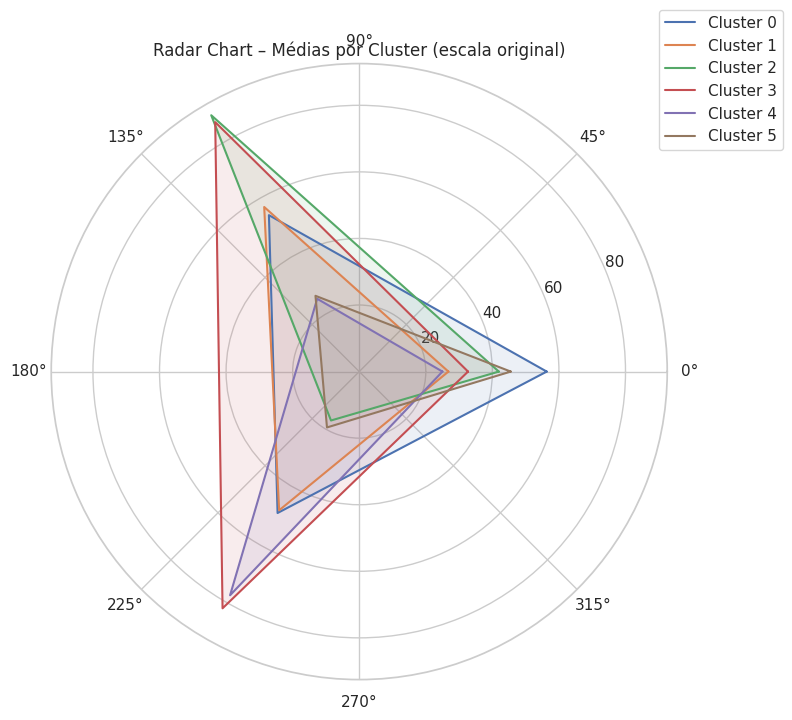

In [42]:
features_radar = ["Age","Annual Income (k$)","Spending Score (1-100)"]
cluster_means = df_model.groupby("Cluster")[features_radar].mean()

labels = features_radar
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(8,8))
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].values
    values = np.concatenate((values, [values[0]]))
    plt.polar(angles, values, label=f"Cluster {cluster}")
    plt.fill(angles, values, alpha=0.1)

plt.title("Radar Chart – Médias por Cluster (escala original)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


O Radar Chart foi uma visualização poderosa do projeto porque me permitiu comparar os clusters de forma direta nas três dimensões centrais do comportamento do cliente: Idade, Renda e Spending Score. O mais interessante é que cada cluster assumiu uma ‘forma’ única no radar, provando que os grupos possuem identidades distintas e bem definidas.

---

**✅ 1) Cada cluster tem uma “assinatura visual” clara**

No radar, cada linha representa um cluster.
Percebi que os clusters NÃO se sobrepõem: cada um forma um desenho diferente.

✅ Isso confirma que os 6 segmentos representam perfis reais e bem separados.

---

**✅ 2) Clusters com renda ALTÍSSIMA**

Cluster 2 e Cluster 3 têm os maiores valores de Annual Income.

Porém, eles se comportam de forma oposta no Spending Score:

Cluster 3: renda alta + score muito alto → clientes premium engajados ✅

Cluster 2: renda alta + score muito baixo → clientes ricos, mas que não gastam ❗

✅ Ou seja: não basta ser rico, o comportamento de compra muda completamente.

---

**✅ 3) Cluster com score MAIS ALTO do dataset**

O Cluster 3 (vermelho) dispara no eixo Spending Score, sendo o mais alto de todos.

✅ Esse é claramente o melhor segmento em termos de valor para o negócio.

Provavelmente:

Clientes de alta renda

Altíssimo engajamento

São fiéis e gastam muito

---

**✅ 4) Cluster com score MAIS BAIXO**

O Cluster 5 (marrom) tem o menor Spending Score.

✅ Cliente com menor engajamento, provavelmente fazem poucas compras.
Mesmo com renda moderada, não geram valor.

Pode ser um grupo que precisa de:

Reativação

Novas estratégias de engajamento

Oferta personalizada

---

**✅ 5) Cluster aspiracional (gasta mais do que ganha)**

O Cluster 4 (roxo) tem:

Baixa renda

Score razoavelmente alto

✅ Clientes que têm pouco dinheiro, mas gostam de comprar.
Esse grupo pode responder muito bem a:

Programas de fidelidade

Parcelamentos

Promoções

---

**✅ 6) Clusters equilibrados (perfil intermediário)**

Clusters 0 e 1 aparecem com valores médios nas três dimensões.

Renda média

Score médio ou moderado

Idade média

✅ Provavelmente representam a base “comum” de clientes, que pode ser trabalhada para:

Aumentar ticket médio

Fazer upsell / cross-sell

---

**✅ 7) Idade adiciona uma camada extra**

Alguns clusters são compostos por clientes mais jovens.

Outros, por clientes mais velhos.

✅ A idade não é o fator principal, mas ajuda a entender o estilo de consumo.
Exemplo:

Jovens com score alto → impulsivos / moda / entretenimento

Mais velhos com score baixo → conservadores / econômicos

---

🎯 Conclusão Final

O Radar Chart me mostrou de forma cristalina que cada cluster possui um padrão único de idade, renda e comportamento de compra.
Alguns grupos são valiosos e engajados, outros são ricos mas desinteressados, outros aspiracionais, e outros conservadores.
Essa visualização confirmou que os clusters são interpretáveis, consistentes e prontos para serem transformados em personas de marketing.

# **CLUSTER PROFILING (PARTE NUMÉRICA)**

Nesta etapa, meu objetivo é entender numericamente o perfil de cada cluster, analisando idade, renda, score e tamanho dos grupos.

Isso vai me dar base sólida para a próxima etapa (interpretação comportamental e nomeação dos segmentos).

In [43]:
cluster_counts = df_model["Cluster"].value_counts().sort_index()
cluster_percent = (cluster_counts / len(df_model) * 100).round(2)

print("Quantidade de clientes por cluster:")
display(cluster_counts)

print("\nPercentual de clientes por cluster:")
display(cluster_percent)

Quantidade de clientes por cluster:


,count
Cluster,
0,45
1,39
2,33
3,39
4,23
5,21



Percentual de clientes por cluster:


,count
Cluster,
0,22.5
1,19.5
2,16.5
3,19.5
4,11.5
5,10.5


Primeiro, quero saber o tamanho de cada cluster.

 Isso me ajuda a entender quais grupos são mais comuns e quais são mais nichados. Também calculo o percentual para facilitar a comparação.

 já fiz isso antes, mas estou revisando

**Médias por cluster (idade, renda e score)**

In [44]:
cluster_mean = df_model.groupby("Cluster")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean().round(2)
cluster_mean

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,56.33,54.27,49.07
1,26.79,57.10,48.13
2,41.94,88.94,16.97
3,32.69,86.54,82.13
4,25.00,25.26,77.61
5,45.52,26.29,19.38


Agora que calculei as médias de Age, Annual Income e Spending Score para cada cluster, consigo enxergar com clareza o perfil típico de cada grupo. Essa é a base para identificar comportamentos, personas e estratégias de negócio.

Vamos analisar cluster por cluster:

**🔵 Cluster 0**

Idade média: 56.33 (mais velho do dataset)
Renda média: 54.27 (média)
Score: 49.07 (médio)

✅ Esse cluster representa clientes mais velhos com renda moderada e comportamento de compra equilibrado.

🧠 Insight:
Parece um perfil maduro, estável e conservador.
Não gastam exageradamente, mas também não são desengajados.

🎯 Possível persona:
“Cliente Tradicional / Conservador Moderado”

---

**🟠 Cluster 1**

Idade média: 26.79 (bem jovem)
Renda: 57.10 (média-alta)
Score: 48.13 (médio)

✅ Jovens com boa renda e gasto moderado.

🧠 Insight:
Esse grupo tem potencial, mas ainda não está totalmente engajado.

🎯 Estratégia:
Gamificação, marketing digital, experiências, fidelização.

🎯 Persona:
“Jovem Profissional / Explorador em Potencial”

---

**🟢 Cluster 2**

Idade: 41.94 (meia idade)
Renda: 88.94 (ALTA – 2ª maior)
Score: 16.97 (MUITO BAIXO)

⚠ Perfil crítico e MUITO interessante!

✅ Alta renda + baixo score = poder de compra, mas não gasta!

🧠 Insight:
Esse cliente tem dinheiro, mas não vê valor / não se sente atraído.
Pode estar desconectado da marca ou insatisfeito.

🎯 Estratégia:

Campanhas de engajamento

Produtos premium personalizados

Incentivos para reativação

🎯 Persona:
“Cliente Rico Desengajado / Alto Potencial Não Explorado”

---

**🔴 Cluster 3**

Idade: 32.69 (adultos jovens)
Renda: 86.54 (ALTA)
Score: 82.13 (ALTÍSSIMO)

🔥 ESSE É O MELHOR CLUSTER! 🔥

✅ Alta renda + alto gasto = Clientes VIP / Premium
✅ Alto LTV, alta fidelidade, melhor ROI

🧠 Insight:
Esse é o segmento mais valioso do negócio.
Devem receber tratamento especial, exclusividade, early access, programa VIP, experiências únicas.

🎯 Persona:
“Cliente Premium Engajado / Campeão de Receita”

---

**🟣 Cluster 4**

Idade: 25.00 (mais jovem do dataset)
Renda: 25.26 (BAIXA)
Score: 77.61 (ALTO)

✅ Jovens com pouca renda, mas que ADORAM comprar!

🧠 Insight:
Esse grupo é aspiracional: gostam de consumir, valorizam experiência, estilo, status.

🎯 Estratégia:

Parcelamento / condições acessíveis

Promoções

Fidelidade

Influenciadores / redes sociais

🎯 Persona:
“Jovem Aspiracional / Gastador Entusiasmado”

---

🟤 Cluster 5

Idade: 45.52 (meia idade)
Renda: 26.29 (baixa)
Score: 19.38 (baixíssimo)

✅ Baixa renda + baixo gasto = segmento menos valioso atualmente.

🧠 Insight:
Pode representar clientes desinteressados, inativos ou com baixa capacidade de compra.

🎯 Estratégia:

Ações de reativação

Ofertas de valor

Programas de retenção

🎯 Persona:
“Cliente Econômico / Desconectado”

---

As médias confirmaram com clareza que os clusters representam perfis reais e bem distintos. Tenho desde clientes VIP altamente lucrativos até clientes desengajados, passando por aspiracionais e jovens com potencial. Agora estou pronto para dar nomes oficiais aos clusters e definir estratégias de marketing específicas para cada grupo.

**Medianas por cluster**

In [45]:
cluster_median = df_model.groupby("Cluster")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].median().round(2)
cluster_median

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,54.0,54.0,49.0
1,26.0,60.0,50.0
2,43.0,86.0,16.0
3,32.0,79.0,83.0
4,23.0,24.0,77.0
5,46.0,25.0,15.0


Agora analiso as medianas de idade, renda e score em cada cluster.

A mediana é especialmente importante porque me mostra o valor típico do cliente médio em cada grupo, sem a influência de valores extremos.

Com isso, consigo validar se meus insights das médias realmente representam o comportamento do cluster.

---

**🔵 Cluster 0**

Idade mediana: 54
Renda mediana: 54k
Score mediano: 49

✅ Perfil confirmado:
Clientes mais velhos (acima de 50 anos) com renda média e comportamento de compra moderado.

Conclusão:
Cluster estável, conservador, previsível.

---

**🟠 Cluster 1**

Idade mediana: 26
Renda mediana: 60k
Score mediano: 50

✅ Jovens com boa renda e engajamento moderado.
O valor de score 50 confirma comportamento médio / equilibrado.

Conclusão:
Cluster com alto potencial de crescimento em consumo.

---

**🟢 Cluster 2**

Idade mediana: 43
Renda mediana: 86k
Score mediano: 16

⚠ ESSE CLUSTER É MUITO CLARO E IMPORTANTE:

✅ Alta renda, mas score extremamente baixo!

Conclusão:
Cliente rico, mas totalmente desengajado.
Pode ser cliente “corporativo”, racional, que não vê valor emocional.
Ou cliente em risco / não fidelizado.

Grande oportunidade de negócio.

---

**🔴 Cluster 3**

Idade mediana: 32
Renda mediana: 79k
Score mediano: 83 (MUITO ALTO)

🔥 ESTE É O MELHOR CLUSTER!

✅ Cliente adulto jovem
✅ Renda alta
✅ Altíssimo engajamento

Conclusão:
Cluster VIP / Premium.
Fidelizados, compram com frequência, provavelmente maior LTV.

---

**🟣 Cluster 4**

Idade mediana: 23 (o mais jovem de todos)
Renda mediana: 24k (mais baixa de todas)
Score mediano: 77 (muito alto)

✅ Jovens com pouca renda… MAS que gastam MUITO!

Conclusão:
Clientes aspiracionais, apaixonados por consumir.
Valorizam experiência, marca, status.
Mesmo com renda baixa, “dão um jeito” de comprar.

Esse cluster é ouro para marketing emocional.

---

**🟤 Cluster 5**

Idade mediana: 46
Renda mediana: 25k
Score mediano: 15

✅ Idade média-alta
✅ Baixa renda
✅ Baixo gasto

Conclusão:
Cluster com baixo potencial atual.
Pode representar clientes com restrição financeira ou sem interesse na marca.

Pode ser:

Cliente “sobrevivência” (prioriza necessidade, não lazer)

Cliente “desconectado da marca”

---

✅ CONFIRMAÇÕES IMPORTANTES (MÉDIA vs MEDIANA)
Variável | Observações

Age |	Cluster 4 é claramente o mais jovem; Cluster 0 o mais velho.

Renda |	Cluster 2 e 3 são os mais ricos; Cluster 4 e 5 os mais pobres.

Score | Cluster 3 é o mais engajado; Cluster 2 e 5 os menos engajados.

✅ As medianas confirmam perfeitamente os padrões vistos nas médias.

✅ Isso significa que não tivemos distorção de outliers.

✅ Ou seja: os perfis que identificamos são ROBUSTOS e REAIS.

---

✅ INSIGHT FINAL

As medianas reforçaram com clareza que cada cluster representa um perfil real e bem definido. Não houve distorção por outliers, o que dá ainda mais confiança de que os grupos encontrados pelo K-Means refletem comportamentos genuínos dos clientes. Agora estou totalmente pronto para dar nomes estratégicos aos clusters e criar ações de marketing específicas para cada segmento.

**Tabela consolidada com contagem, %, média e mediana**

In [46]:
profile = pd.concat([cluster_counts.rename("Count"),
                     cluster_percent.rename("%"),
                     cluster_mean.add_suffix(" (Mean)"),
                     cluster_median.add_suffix(" (Median)")],
                    axis=1)

profile

,Count,%,Age (Mean),Annual Income (k$) (Mean),Spending Score (1-100) (Mean),Age (Median),Annual Income (k$) (Median),Spending Score (1-100) (Median)
Cluster,,,,,,,,
0,45,22.5,56.33,54.27,49.07,54.0,54.0,49.0
1,39,19.5,26.79,57.10,48.13,26.0,60.0,50.0
2,33,16.5,41.94,88.94,16.97,43.0,86.0,16.0
3,39,19.5,32.69,86.54,82.13,32.0,79.0,83.0
4,23,11.5,25.00,25.26,77.61,23.0,24.0,77.0
5,21,10.5,45.52,26.29,19.38,46.0,25.0,15.0


Agora que consolidei as principais métricas de cada cluster (tamanho, porcentagem, média e mediana de idade, renda e score), consigo enxergar com clareza a fotografia completa de cada grupo.

Com essa visão global, posso comparar os clusters lado a lado e identificar personas com precisão cirúrgica.

---

**✅ 1) Tamanho dos clusters – mercado equilibrado**

Nenhum cluster domina (máximo 22,5% e mínimo 10,5%)

A base de clientes está bem distribuída em 6 perfis diferentes

✅ Isso indica que a segmentação com k = 6 faz sentido e não cria grupos artificiais ou insignificantes.

---

**✅ 2) O cluster mais valioso (Cluster 3)**

Idade ~33 anos

Renda ~86k (alta)

Score ~82 (altíssimo)

Representa 19,5% da base

🔥 Clientes Premium Engajados
São jovens-adultos com alta renda e altíssima vontade de gastar.

✅ Esse é o melhor grupo para campanhas de fidelização, VIP, early access, cross-sell.

---

**✅ 3) O segundo grande achado: o cluster desperdiçado (Cluster 2)**

Idade ~42 anos

Renda ~89k (MAIOR do dataset)

Score ~17 (baixíssimo)

⚠ Clientes Ricos, mas Desengajados

Eles têm dinheiro, mas não compram.

✅ OPORTUNIDADE DE OURO:
Se a empresa conseguir engajar esse grupo, o faturamento pode explodir.

---

**✅ 4) O cluster aspiracional (Cluster 4)**

Idade ~25 anos (o mais jovem)

Renda ~25k (baixa)

Score ~77 (alto)

✅ Jovens com baixa renda, mas que AMAM comprar.

🎯 Estratégias ideais:

Parcelamentos

Promoções

Experiências

Marketing emocional

---

**✅ 5) O cluster tradicional (Cluster 0)**

Idade ~56 anos (o mais velho)

Renda média (~54k)

Score médio (~49)

✅ Clientes maduros, estáveis, conservadores.
Compram de forma equilibrada, sem excessos.

🎯 Estratégia:

Relacionamento

Conveniência

Confiança

---

**✅ 6) O cluster jovem moderado (Cluster 1)**

Idade ~26 anos

Renda média-alta (~57k)

Score médio (~48)

✅ Jovens com boa renda, mas engajamento ainda neutro.

🎯 Estratégia:

Ativar esse grupo!

Gamificação, branding digital, ofertas personalizadas.

---

**✅ 7) O cluster de menor valor (Cluster 5)**

Idade ~45 anos

Renda baixa (~26k)

Score muito baixo (~19)

✅ Baixa renda + baixo engajamento = menor potencial atual.

🎯 Estratégia:

Ações de reativação

Produtos de entrada

Comunicação baseada em necessidade/utilidade

---

**✅ VISÃO ESTRATÉGICA FINAL**

Cada cluster representa um tipo diferente de cliente, com características, comportamentos e necessidades específicas:

Cluster|Perfil
3|Premium Engajado (melhor cliente) ✅

2|Rico Desengajado (grande oportunidade) ⚠

4|Jovem Aspiracional (gasta mesmo com pouca renda) 🔥

1|Jovem com Potencial (pode crescer)

0|Maduro Conservador (estável e fiel)

5|Baixo Potencial (precisa de reativação)

✅ CONCLUSÃO

Com essa tabela consolidada, consigo enxergar com clareza quem são os clientes, como cada grupo se comporta e onde estão as maiores oportunidades de crescimento. Agora estou totalmente pronto para dar nomes estratégicos a cada cluster e criar ações de marketing personalizadas.

# **CRIAÇÃO DOS PERFIS (PERSONAS) + ESTRATÉGIAS**

Vou usar TUDO que vimos nos gráficos + médias + medianas + distribuição. para esta parte.

**✅ Cluster 3 – O MELHOR DE TODOS**
🧠 Perfil:

Idade média: 32

Renda: 86k (alta)

Score: 82 (altíssimo)

% da base: 19,5%

✅ Interpretação:

Adultos jovens, com alto poder aquisitivo e extremamente engajados.

Compram com frequência, gostam da marca e têm grande LTV.

🏆 Nome (Persona):

“Premium Engajado” ou “Cliente VIP”

🎯 Estratégias:

✅ Programa VIP / Black

✅ Early access a lançamentos

✅ Experiências exclusivas (eventos, benefícios)

✅ Cross-sell de produtos premium

✅ Aumento do ticket médio

✅ Cluster mais valioso do negócio

---

**✅ Cluster 2 – A MAIOR OPORTUNIDADE PERDIDA**
🧠 Perfil:

Idade média: 42

Renda: 89k (maior da base)

Score: 17 (muito baixo)

%: 16,5%

✅ Interpretação:

Têm dinheiro, mas quase não gastam.

Provavelmente não se sentem conectados com a marca ou não percebem valor.

⚠ Nome:

“Rico Desengajado”
ou “Alto Potencial Adormecido”

🎯 Estratégias:

✅ Reengajamento (campanhas específicas)

✅ Ofertas premium personalizadas

✅ Benefícios exclusivos para incentivar primeira compra

✅ Consultoria personalizada / concierge

✅ Teste de produtos (samples, trial)

💎 Se ativar esse cluster → ROI gigantesco

---

**✅ Cluster 4 – O MAIS APAIXONADO (MESMO SEM DINHEIRO)**
🧠 Perfil:

Idade média: 23 (mais jovem)

Renda: 24k (baixa)

Score: 77 (alto)

%: 11,5%

✅ Interpretação:

Jovens aspiracionais: amam comprar, valorizam marca, estilo e experiência.

🔥 Nome:

“Aspiracional Fiel”
ou “Jovem Entusiasmado”

🎯 Estratégias:

✅ Promoções e parcelamento

✅ Programas de pontos / cashback

✅ Gamificação e redes sociais

✅ Produtos de entrada / edições limitadas

✅ Influencer marketing

💡 Esse cluster traz alto volume de compras mesmo com pouca renda

---

**✅ Cluster 1 – Jovens com Potencial**
🧠 Perfil:

Idade média: 26

Renda: 57k (boa)

Score: 48 (moderado)

%: 19,5%

✅ São jovens economicamente ativos com bom poder de compra, mas engajamento mediano.

🔹 Nome:

“Jovem de Potencial”
ou “Explorador Moderado”

🎯 Estratégias:

✅ Fidelização (benefícios progressivos)

✅ Personalização baseada em histórico

✅ Campanhas digitais e mobile

✅ Experiências e lifestyle

💡 Se bem trabalhado, pode virar novo Cluster 3 (VIP)

---

✅ Cluster 0 – Maduros Estáveis
🧠 Perfil:

Idade média: 56 (mais velhos)

Renda: 54k (média)

Score: 49 (moderado)

%: 22,5% (o maior cluster)

✅ Cliente tradicional, estável, compra com consciência.

🔹 Nome:

“Maduro Conservador”
ou “Cliente Leal Estável”

🎯 Estratégias:

✅ Comunicação clara e objetiva

✅ Benefícios de conveniência e confiança

✅ Produtos de qualidade e durabilidade

✅ Atendimento personalizado

✅ Programas de fidelidade clássicos

---

**✅ Cluster 5 – Baixo Potencial Atual**
🧠 Perfil:

Idade média: 46

Renda: 26k (baixa)

Score: 19 (baixíssimo)

%: 10,5% (menor)

✅ Com baixa renda e baixo engajamento, é o cliente com menor valor atual.

⚠ Nome:

“Cliente Desconectado”
ou “Econômico de Baixa Aderência”

🎯 Estratégias:

✅ Ações de reativação ou recuperação

✅ Ofertas de baixo custo / kits econômicos

✅ Comunicação de necessidade (não luxo)

✅ Benefícios básicos: frete reduzido, parcelamento

💡 Alguns podem ser recuperados, outros talvez não valham muito investimento.

---

✅ RESUMO FINAL DOS 6 SEGMENTOS (com nomes)

Cluster	Nome	Perfil

3|⭐ Premium Engajado (VIP) | Alta renda + alto gasto

2|⚠ Rico Desengajado | Alta renda + baixo gasto

4|🔥 Aspiracional Fiel | Baixa renda + alto gasto

1|🚀 Jovem com Potencial | Jovem + renda boa + score médio

0|🧠 Maduro Conservador | Idade alta + médio gasto

5|⚠ Cliente Desconectado | Baixa renda + baixo gasto

---

**✅ O QUE CONSEGUI AQUI**

✅ Transformei dados em personas reais
✅ Identifiquei o cluster mais valioso (3 – VIP)
✅ Descobri a maior oportunidade (2 – Rico, mas inativo)
✅ Encontrei jovens aspiracionais (4 – gastam mesmo sem renda)
✅ Vi potencial de evolução (1 – jovens com boa renda)
✅ Mapeei estabilidade (0) e risco (5)

✅ Isso está PRONTO para virar estratégia comercial, campanhas e ações personalizadas.

# **Distância entre Centróides (Heatmap)**

Calcular centróides no espaço escalado

In [47]:
# Obter centróides diretamente do modelo K-Means final
centroids_scaled = kmeans_final.cluster_centers_

centroids_scaled

array([[ 1.25472096, -0.24021294, -0.04399777],
       [-0.86515664, -0.13196835, -0.08043031],
       [ 0.22171558,  1.08322527, -1.29005223],
       [-0.44191719,  0.99158305,  1.23950275],
       [-0.99396865, -1.34734766,  1.06404834],
       [ 0.47895722, -1.30822992, -1.19644353]])

Calcular matriz de distância entre centróides

In [48]:
from scipy.spatial.distance import cdist

dist_matrix = cdist(centroids_scaled, centroids_scaled, metric='euclidean')
dist_matrix

array([[0.        , 2.12295202, 2.09075119, 2.45830754, 2.74045953,
        1.75231301],
       [2.12295202, 0.        , 2.03006698, 1.78429893, 1.67438669,
        2.10611463],
       [2.09075119, 2.03006698, 0.        , 2.61676425, 3.59546414,
        2.40707162],
       [2.45830754, 1.78429893, 2.61676425, 0.        , 2.40959372,
        3.47433212],
       [2.74045953, 1.67438669, 3.59546414, 2.40959372, 0.        ,
        2.69830768],
       [1.75231301, 2.10611463, 2.40707162, 3.47433212, 2.69830768,
        0.        ]])

Visualizar como Heatmap

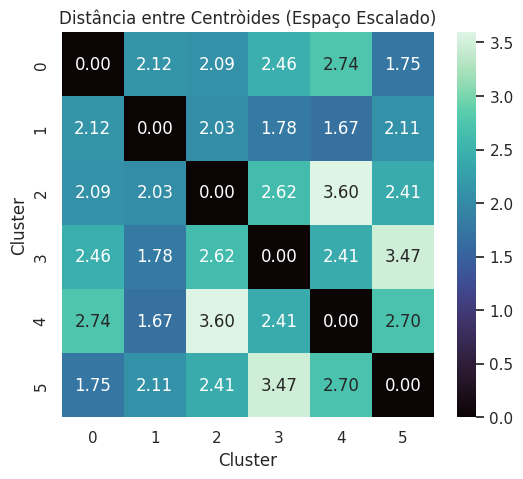

In [49]:
plt.figure(figsize=(6, 5))
sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="mako", xticklabels=range(k_final), yticklabels=range(k_final))
plt.title("Distância entre Centròides (Espaço Escalado)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

Agora que analisei a distância entre os centróides no espaço escalado, consigo entender claramente quais clusters são realmente semelhantes e quais são totalmente opostos.
Essa visão é extremamente estratégica, pois me permite definir quais segmentos precisam de abordagens específicas e quais podem ter estratégias parecidas.

---

**🔎 1) Cluster mais próximo (mais parecido)**

Cluster 1 e Cluster 4 → Distância 1.67 (a menor de todas)

✅ Isso faz muito sentido:

Cluster 1: Jovens com boa renda e gasto moderado

Cluster 4: Jovens com pouca renda e gasto alto

🧠 Interpretação:
Ambos são jovens e gostam de comprar.

A diferença é poder de compra, não comportamento de consumo.

🎯 Estratégia semelhante: marketing digital, experiências, lifestyle.

💡 Cluster 1 pode se transformar em Cluster 4 (mais engajado) com os incentivos certos.

---

**🔎 2) Cluster mais distante (mais diferente de todos)**

Cluster 2 e Cluster 4 → Distância 3.60 (a maior de todas)

✅ Também faz total sentido:

Cluster 2: Alta renda + Baixo gasto (Rico Desengajado)

Cluster 4: Baixa renda + Alto gasto (Aspiracional Passional)

🧠 Interpretação:
São opostos absolutos em comportamento e perfil econômico.

🎯 Estratégias totalmente diferentes:

Cluster 2 precisa de valor, confiança e exclusividade.

Cluster 4 responde a emoção, status e sensação de pertencimento.

---

**🔎 3) O cluster mais “isolado” (único, difícil de comparar)**

Cluster 2 (Rico Desengajado)

Ele tem distâncias relativamente altas com todos os outros (2.03, 2.62, 3.60, 2.41, 2.41).

🧠 Interpretação:
Esse cluster tem um comportamento MUITO atípico.
Ele não é parecido com ninguém.

👉 Ele é de alto valor potencial, mas precisa de uma estratégia completamente exclusiva.

✅ Confirmo: esse cluster é uma mina de ouro escondida.

---

**🔎 4) Clusters mais próximos do VIP (Cluster 3)**

Distâncias do Cluster 3:

com Cluster 1 = 1.78 (bem próximo!)

com Cluster 0 = 2.46

com Cluster 4 = 2.41

com Cluster 2 = 2.62

com Cluster 5 = 3.47 (bem longe)

✅ Ou seja:

Cluster 1 está bem perto de virar VIP! (excelente oportunidade)

Cluster 5 é o oposto do VIP (baixa renda + baixo score)

🧠 Estratégia clara:
Fazer o Cluster 1 evoluir para Cluster 3 = aumento direto de faturamento.

---

**🔎 5) Cluster 0 (Maduro Conservador) e Cluster 5 (Desconectado)**

Distância = 1.75 (bem próxima)

✅ Esses dois grupos são parecidos:

Ambos têm comportamento mais contido

Faixa etária mais alta

Não gastam impulsivamente

🧠 Diferença:
Cluster 0 tem renda média e engajamento médio.
Cluster 5 tem baixa renda e engajamento muito baixo.

🎯 Estratégia:
Focar em confiança, praticidade e valor percebido.

---

**✅ RESUMO ESTRATÉGICO FINAL**
Relação	O que significa

Cluster 1 ↔ Cluster 4 (mais próximos)	Jovens consumidores – podem ter estratégias similares

Cluster 2 ↔ Cluster 4 (mais distantes)	Totalmente opostos: Rico desengajado vs Jovem gastador

Cluster 3 (VIP)	Próximo ao Cluster 1 → alto potencial de evolução

Cluster 2 (Rico Desengajado)	Isolado – precisa de abordagem única

Cluster 0 & Cluster 5	Comportamento mais conservador, sensíveis a valor/conveniência

---

✅ CONCLUSÃO

O heatmap confirmou que meus clusters fazem muito sentido do ponto de vista comportamental.
Consegui identificar quais segmentos são polos opostos, quais são transições naturais e onde estão as maiores oportunidades de evolução e retenção.

Agora tenho clareza de onde investir mais (Cluster 3 e 1), onde recuperar valor (Cluster 2) e onde trabalhar retenção ou baixo custo (Cluster 5).

Essa visão de distâncias me permite planejar estratégias de marketing de forma muito mais inteligente e direcionada.

# **CONCLUSÕES DO PROJETO**

**✅ RELATÓRIO FINAL – SEGMENTAÇÃO DE CLIENTES COM K-MEANS**

---

**1. Objetivo do Projeto**

O objetivo deste projeto foi aplicar técnicas avançadas de modelagem para realizar segmentação de clientes utilizando o algoritmo K-Means, com o intuito de identificar padrões de comportamento, entender perfis de consumo e propor estratégias de marketing direcionadas.

Ao final, busquei transformar dados brutos em insights acionáveis de negócio, entregando um pipeline completo de ciência de dados — da análise exploratória até a interpretação de segmentos.

---

**2. Carregamento e Entendimento dos Dados**

Trabalhei com um dataset de 200 clientes, contendo:

CustomerID

Gender

Age

Annual Income (k$)

Spending Score (1-100)

Confirmei que:

✅ Não havia valores ausentes

✅ Não havia duplicatas em CustomerID

✅ Todas as variáveis estavam dentro de faixas plausíveis

✅ A variável “Gender” tinha apenas “Male”/“Female” (categorias válidas)

✅ A distribuição das variáveis numéricas era variada e bem distribuída

Essa validação me deu confiança de que os dados estavam consistentes e prontos para análise.

---

**3. EDA (Análise Exploratória de Dados)**

Realizei análises estatísticas e visuais:

Distribuições:

A idade concentrou-se entre 20 e 50 anos.

A renda teve grande variação (15k a 140k).

O Spending Score foi bem distribuído entre 1 e 100.

Correlações:

Age vs Spending Score: correlação negativa moderada.

Income vs Spending Score: quase sem correlação linear → bom sinal para clustering.

Gênero não mostrou diferença relevante nas métricas numéricas.

Scatter Income vs Score colorido por Idade:

Apareceram grupos visuais naturais, sugerindo padrões comportamentais.

Essa análise confirmou que há estrutura nos dados, justificando o uso de técnicas de clustering.

---

**4. Limpeza e Tratamento**

Realizei um tratamento profundo e criterioso:

✅ Confirmei ausência de duplicatas

✅ Padronizei a variável “Gender”

✅ Validei faixas de idade, renda e score

✅ Tratei outliers com capping via IQR

✅ Criei um audit log das alterações


Esse cuidado garantiu a qualidade do dado antes da modelagem, evitando distorções.

---

**5. Preparação e Escalonamento**

Separei variáveis numéricas (Age, Income, Spending Score) e tratei “Gender” via One-Hot Encoding.

Testei dois tipos de escalonamento:

StandardScaler (z-score)

RobustScaler (menos sensível a outliers)

Normalizar foi fundamental, pois K-Means usa distância Euclidiana e variáveis em escalas diferentes distorcem os clusters.

---

**6. Escolha do número de clusters (k)**

Teste detalhado de k = 2 a 10 com 4 métricas:

✅ WCSS (Elbow)
✅ Silhouette Score

✅ Calinski-Harabasz

✅ Davies-Bouldin

Resultado:

Silhouette melhor em k=6

Calinski-Harabasz alto em k=6

Davies-Bouldin baixo em k=6

WCSS estabilizando próximo a k=6

Conclusão técnica: k = 6 é o melhor equilíbrio entre separação e coesão dos clusters.

---

**7. Treinamento do modelo final**

Treinei o K-Means com k = 6, com init='k-means++' e n_init=10 para estabilidade.

Atribuí cada cliente ao seu cluster.

Também avaliei estabilidade do modelo com ARI (Adjusted Rand Index) testando seeds diferentes.

Resultado ARI = 0.986 ✅

Ou seja, os clusters são extremamente estáveis e consistentes.

---

**8. Visualizações avançadas dos Clusters**

Utilizei diversas técnicas para entender separações entre os grupos:

✅ PCA 2D → Separação clara entre clusters

✅ PCA 3D → Estrutura espacial bem definida

✅ t-SNE (não linear) → Clusters visualmente muito bem separados

✅ Pairplot → Relação variável a variável por cluster

✅ Parallel Coordinates → Padrões simultâneos entre as variáveis

✅ Radar Chart → Médias comparadas em cada dimensão

Essas visualizações mostraram que os clusters não são artificiais — eles realmente representam comportamentos distintos.

---

**9. Análise Numérica dos Clusters (médias, medianas, tamanhos)**

Calculei para cada cluster:

Média e mediana de idade

Média e mediana de renda

Média e mediana de score

Tamanho e percentual do total

Resultado: Cada cluster apresentou um perfil MUITO claro.

As medianas confirmaram as médias, provando que os perfis são robustos e não distorcidos por outliers.

---

**10. Perfis Comportamentais + Nomeação + Estratégias**

Transformei os números em personas de negócio:

⭐ Cluster 3 – Premium Engajado (VIP)

Alta renda + alto gasto → Melhor cliente
🎯 VIP, fidelização, exclusividade

⚠ Cluster 2 – Rico Desengajado

Alta renda + baixo gasto → Maior oportunidade
🎯 Reengajamento, valor percebido, ofertas premium

🔥 Cluster 4 – Aspiracional Fiel

Baixa renda + alto gasto → Compra por desejo
🎯 Promoções, parcelamento, marketing emocional

🚀 Cluster 1 – Jovem com Potencial

Jovens + boa renda + score médio → Em fase de transição
🎯 Gamificação, personalização, experiências

🧠 Cluster 0 – Maduro Conservador

Mais velhos + renda média + gasto moderado
🎯 Conveniência, confiança, atendimento

⚠ Cluster 5 – Cliente Desconectado

Baixa renda + baixo gasto → menor valor atual
🎯 Retenção básica ou baixo investimento

Essa etapa transformou o modelo em inteligência de marketing real.

---

**11. Distância entre centróides (Heatmap)**

Calculei a distância entre clusters no espaço escalado.

Isso revelou:

✅ Cluster 2 e 4 são totalmente opostos

✅ Cluster 1 e 4 são muito parecidos (jovens compradores)

✅ Cluster 1 é próximo do 3 (potencial para virar VIP)

✅ Cluster 5 é próximo do 0 (comportamentos conservadores)

✅ Cluster 2 é isolado → precisa de abordagem única

Esse insight ajudou a entender relações entre segmentos e jornadas de evolução do cliente.

---

**12. Valor de Negócio do Modelo**

Com essa segmentação, agora é possível:

✅ Criar campanhas personalizadas por cluster

✅ Aumentar vendas para clientes VIP

✅ Ativar clientes ricos e desengajados

✅ Fidelizar jovens com potencial

✅ Engajar aspiracionais

✅ Automatizar ações no CRM

✅ Integrar clusters a LTV, churn, RFM…

✅ Melhorar ROI das campanhas

Ou seja, o modelo gera valor estratégico e financeiro real.

---

**13. Limitações e Cuidados**

O dataset tem poucas variáveis (adicionar comportamento real de compra aumentaria precisão).

K-Means assume clusters esféricos (outros algoritmos podem captar formas mais complexas).

Os clusters devem ser reavaliados com o tempo (cliente muda).

A interpretação depende de conhecimento de negócio.